<a href="https://colab.research.google.com/github/geewynn/nlp_projects/blob/master/stackoverflow_tag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Packages

In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from scipy.sparse import hstack
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

#Handle Kaggle Installation and Connection

In [3]:
#install kaggle api

from google.colab import files
!pip install kaggle

In [0]:
!mkdir .kaggle
!touch .kaggle/kaggle.json

In [0]:
!mv .kaggle /root/

In [5]:
#upload kaggle json file

uploaded = files.upload()

Saving kaggle.json to kaggle.json


Connected kaggle api to google colab so I can download the data directle from kaggle.
  - You need the kaggle api to access the kaggle data

In [9]:
api_token = {"username":"geewynn","key":"b5dd5e9253a91c876fe288606e440250"}

import json
import zipfile

import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /content/.kaggle/kaggle.json
!kaggle config path -p /content

chmod: cannot access '/content/.kaggle/kaggle.json': No such file or directory
usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')


- Download the data by getting the api link associated with the dataset from kaggle

In [11]:
!kaggle datasets download -d stackoverflow/stacksample

 99% 1.10G/1.11G [00:36<00:00, 31.8MB/s]
100% 1.11G/1.11G [00:36<00:00, 32.8MB/s]


- Unzip the data

In [12]:
!unzip '/content/stacksample.zip'

Archive:  /content/stacksample.zip
  inflating: Answers.csv             
  inflating: Questions.csv           
  inflating: Tags.csv                


# Data Handling and Preprocessing

- Read in the data with panda read_csv method

In [0]:
questions = pd.read_csv('Questions.csv', encoding='latin-1')
tags = pd.read_csv('Tags.csv', encoding='latin-1')

- Print out the first 5 rows of our data

In [74]:
questions.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [75]:
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


- Count of each tags. This shows us how often each individual has been used.
  - We can see that javascript has the highest.
    -  This can mean Javascript is the most popular tag.
    -  Most questions tend to be from Javascript users.
    -  Most issues originated from Javascript.

  - The least being setenvif(I don't know what that is, probably should do a research on it) is the least popular.
  

In [76]:
tags['Tag'].value_counts()

javascript         124155
java               115212
c#                 101186
php                 98808
android             90659
                    ...  
tab-size                1
itil                    1
tag-handler             1
virtual-pc-2007         1
commercetools           1
Name: Tag, Length: 37034, dtype: int64

- The info below gives us a more detailed information about our features
  - We have to integer columns and one float column
  - We have $ object columns
  - CreationDate and ClosedDate should be converted to datetime.

In [77]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
Id              1264216 non-null int64
OwnerUserId     1249762 non-null float64
CreationDate    1264216 non-null object
ClosedDate      55959 non-null object
Score           1264216 non-null int64
Title           1264216 non-null object
Body            1264216 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


- Datetime Handling. We convert the datetime columns to datetime.

In [0]:
questions['CreationDate'] = pd.to_datetime(questions['CreationDate'])
questions['ClosedDate'] = pd.to_datetime(questions['ClosedDate'])

- Make a copy of our questions data set.
 - We do this becaues we want to carry out analysis on our data set.

In [0]:
time_df = questions.copy()

- Create new columns from our datetime column to get more insight from the data.

In [0]:
time_df['week'] = time_df['CreationDate'].dt.week
time_df['day'] = time_df['CreationDate'].dt.day
time_df['year'] = time_df['CreationDate'].dt.year

- Print out our new data set

In [81]:
time_df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,week,day,year
0,80,26.0,2008-08-01 13:57:07+00:00,NaT,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,31,1,2008
1,90,58.0,2008-08-01 14:41:24+00:00,2012-12-26 03:45:49+00:00,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,31,1,2008
2,120,83.0,2008-08-01 15:50:08+00:00,NaT,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,31,1,2008
3,180,2089740.0,2008-08-01 18:42:19+00:00,NaT,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,31,1,2008
4,260,91.0,2008-08-01 23:22:08+00:00,NaT,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,31,1,2008


- Group the dataset accourding to posts per week

In [82]:
post_per_week = time_df.groupby('week')
post_per_week.first()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,day,year
week,,,,,,,,,
1,396930,48499.0,2008-12-29 01:08:20+00:00,2015-06-05 03:11:49+00:00,18,The future direction of Help File formats,<p>It would appear that CHM help files are no ...,29,2008
2,412010,2136.0,2009-01-05 00:48:55+00:00,2014-07-14 08:43:35+00:00,2,RewriteRule but keep the subdomain,<p>I would like to redirect the following as a...,5,2009
3,434140,51133.0,2009-01-12 00:53:36+00:00,2014-12-21 23:12:13+00:00,6,Array of structs and new / delete,<p>I have a struct like this:</p>\n\n<pre><cod...,12,2009
4,456220,19570.0,2009-01-19 00:31:08+00:00,2012-11-19 11:57:51+00:00,3,Debugging ASP.NET Session State server issues,<p>We have an application that runs over load ...,19,2009
5,478570,58729.0,2009-01-26 00:07:55+00:00,2014-07-24 11:32:24+00:00,29,Recursion or iteration?,<p>I love recursion. I think it simplifies thi...,26,2009
6,501940,54964.0,2009-02-02 00:55:03+00:00,2014-03-27 20:18:38+00:00,7,Simple simulations for Physics in Python?,"<p>I would like to know similar, concrete simu...",2,2009
7,526890,1154.0,2009-02-09 01:35:11+00:00,2013-10-25 17:46:19+00:00,46,Best OpenId API for ASP.NET MVC application,<p>I am developing an ASP.NET MVC application ...,9,2009
8,551880,62037.0,2009-02-16 00:04:40+00:00,2012-11-07 10:36:29+00:00,-1,What are your recommended Windows Server 2003 ...,<p>What tools do you guys recommend for backin...,16,2009
9,576240,12448.0,2009-02-23 01:02:34+00:00,2012-05-15 16:23:59+00:00,1,How can I unobtrusively disable submit buttons...,"<p>So I found <a href=""http://stackoverflow.co...",23,2009


In [83]:
post_per_week.get_group(1)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,day,year
5714,396930,48499.0,2008-12-29 01:08:20+00:00,NaT,18,The future direction of Help File formats,<p>It would appear that CHM help files are no ...,29,2008
5715,397210,11100.0,2008-12-29 05:54:21+00:00,NaT,0,CommandBars.FindControl throwing an exception,<p>I am trying to use the FindControl Method o...,29,2008
5716,397250,23845.0,2008-12-29 06:51:44+00:00,NaT,30,Unicode Regex; Invalid XML characters,<p>The list of valid XML characters is well kn...,29,2008
5717,397320,49772.0,2008-12-29 08:12:59+00:00,NaT,1,Frame position in JavaScript,<p>I am having a frame-based webpage with 3 fr...,29,2008
5718,397390,352728.0,2008-12-29 09:33:05+00:00,NaT,3,How do firefox extensions make use of the whol...,"<p>I understand that <a href=""http://www.mozil...",29,2008
...,...,...,...,...,...,...,...,...,...
1058943,34712170,754865.0,2016-01-10 23:45:42+00:00,NaT,0,$cordovaFileTransfer not working,<p>Am trying to user the $cordovaFileTransfer ...,10,2016
1058944,34712190,5578926.0,2016-01-10 23:48:00+00:00,NaT,-1,logrotate keep old file names,<p>By default log rotate shifts file name's in...,10,2016
1058945,34712240,5763552.0,2016-01-10 23:56:41+00:00,NaT,0,Scroll top navigation won't work in mobile,<p>The header on scroll should slide up/down a...,10,2016
1058946,34712260,3186199.0,2016-01-10 23:59:36+00:00,NaT,1,MongoDB 3.2 Java Driver: How To Use AggregateO...,<p>I am interested in example code for using t...,10,2016


- Here we plot the number of post per week
  - From the plot we can see that number of post increases as the year progresses.
  

Text(0, 0.5, 'post count per year')

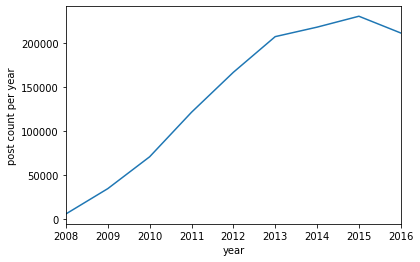

In [84]:
time_df_week =time_df.set_index('CreationDate')
post_count_year = time_df_week.groupby('year')['Title'].count()
ax = post_count_year.plot()
ax.set_ylabel('post count per year')

- Here we plot the weekly post count.
  - Not much different from the post pear year.
  - There seem to be a rapid drop after 50. Will look into this later

Text(0, 0.5, 'weekly post count')

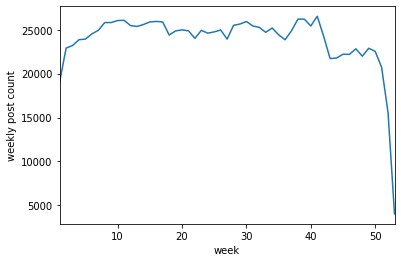

In [85]:
post_count_week = time_df_week.groupby('week')['Title'].count()
ax = post_count_week.plot()
ax.set_ylabel('weekly post count')

In [0]:
# A function to plot the tag counts
def plot_tags(tagCount):
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/4000 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(10,6))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()  

- We use the python collection.Counter to get the most common counter and plot them.
  - The plot contains the tag count of th 20 most common tag
  *Things we can do
    - get the mention of each tag per year and plot

[('javascript', 124155), ('java', 115212), ('c#', 101186), ('php', 98808), ('android', 90659), ('jquery', 78542), ('python', 64601), ('html', 58976), ('c++', 47591), ('ios', 47009), ('mysql', 42464), ('css', 42308), ('sql', 35782), ('asp.net', 29970), ('objective-c', 26922), ('ruby-on-rails', 25789), ('.net', 24059), ('c', 23238), ('iphone', 21539), ('angularjs', 20345)]


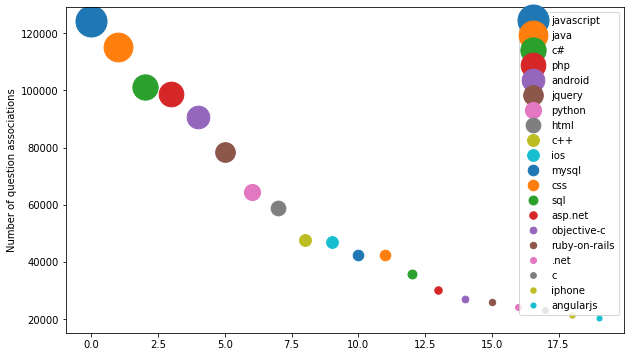

In [87]:
import collections
import matplotlib.pyplot as plt
tagCount =  collections.Counter(list(tags['Tag'])).most_common(20)
print(tagCount)
plot_tags(tagCount)

In [88]:
print('Question dataset shape is', questions.shape)
print('The tag data set shape is', tags.shape)
print('-------------------------------------------------')
print(tags.info())

Question dataset shape is (1264216, 7)
The tag data set shape is (3750994, 2)
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
Id     int64
Tag    object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB
None


- Convert the tag column from the tag data set to strings
- Group the tags by their ID and split them with a space
- print the top 5 grouped tags

In [89]:
tags['Tag'] = tags['Tag'].astype(str)
grouped_tags = tags.groupby('Id')['Tag'].apply(lambda tags: ' '.join(tags))
grouped_tags.head()

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

- Merge the two data set on the ID so we have the all tags a user used on on single question.
- Print the head.

In [113]:
final_df = questions.merge(grouped_tags, on='Id')
final_df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tag
0,80,26.0,2008-08-01 13:57:07+00:00,NaT,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,58.0,2008-08-01 14:41:24+00:00,2012-12-26 03:45:49+00:00,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,83.0,2008-08-01 15:50:08+00:00,NaT,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,2089740.0,2008-08-01 18:42:19+00:00,NaT,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,91.0,2008-08-01 23:22:08+00:00,NaT,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


- Drop unnecessary columns

In [0]:
columns=['OwnerUserId', 'CreationDate', 'ClosedDate']

final_df.drop(columns, axis=1, inplace=True)

In [115]:
#confirm that the columns have been dropped
final_df.head()

,Id,Score,Title,Body,Tag
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


- We will only use dataset with score greater than 5.
  - This is because they might not add any performance to our model
  - To reduce the number of irrelevat columns on our data.
  - For better performance and faster training.

In [0]:
question = final_df[final_df['Score']>5]

- Drop the ID and Score. They will not be used in our model

In [117]:
question.drop(columns = ['Id','Score'],inplace=True)
question.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Title,Body,Tag
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


- Split each tag and add them to the all_tag list
- We do this because:
  - We want to get some insights from the tags

In [118]:
#question['Tag'] = question['Tag'].astype(str)
question['Tag'] = question['Tag'].apply(lambda x: x.split())
all_tag = [item for sublist in question['Tag'].values for item in sublist]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


- Get the lenght of tags
 - We have a total of 224129 tags

In [119]:
len(all_tag)

224129

- We have a total of 14883 unique tags

In [120]:
my_set = set(all_tag)
unique_tags = list(my_set)
len(unique_tags)


14883

- We get the most frequent tags using the nltk Frequency Distribution method.
 - We will work with the top 100 most frequent tags
 - This will cause our data set to be more structure

In [0]:
flat_list = [item for sublist in question['Tag'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [122]:
len(tags_features)

100

- A plot of the top 100 tags in our tag feature
 - The top 5 tags are C#, Java, Javascript, Android and Python.
 - You will notice C# is the most frequent in our current data set.

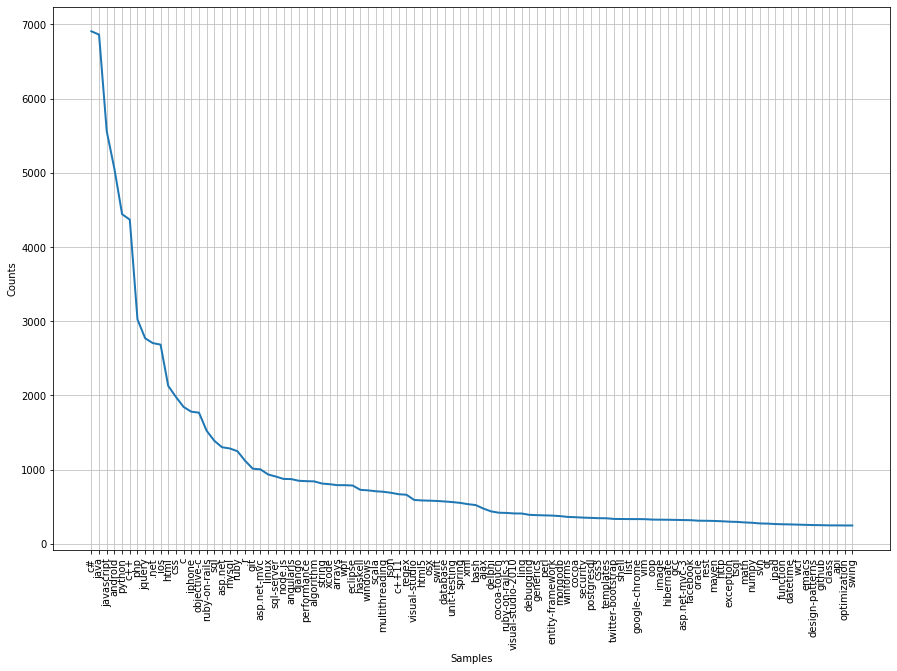

In [123]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

- We create a function to apply the most common tags to our question dataset

In [0]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [125]:
question['Tag'] = question['Tag'].apply(lambda x: most_common(x))
question['Tag'] = question['Tag'].apply(lambda x: x if len(x)>0 else None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


- We are going to drop tags not in our most frequent subset

In [126]:
question.dropna(subset=['Tag'], inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [127]:
question.shape

(63167, 3)

In [128]:
question.head()

,Title,Body,Tag
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
5,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class]"


- Now we have reach the point of our text processing
  - We need to do this because we can't feed text data into our model.
  - We start with text cleaning and end it with text vectorizer.
  - Most of the idea gotten for this section are from this notebook. https://github.com/Utkarsh4430/Autonomous-Tagging-Of-Stack-Overflow-Questions/blob/master/predicting-tags.ipynb

- Below we define a clean_text function and apply it to the data set.
  - Applying the function to the body  removes links, code tags, replaces contractions and converts to lowercase

In [129]:
def clean_text(text):
  global EMPTY
  EMPTY = ''
    
  if not isinstance(text, str): 
      return text
  text = re.sub('<pre><code>.*?</code></pre>', EMPTY, text)

  def replace_link(match):
      return EMPTY if re.match('[a-z]+://', match.group(1)) else match.group(1)
    
  text = re.sub('<a[^>]+>(.*)</a>', replace_link, text)
  return re.sub('<[^>]+>', EMPTY, text)

  text = text.lower()
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"\'s", " ", text)
  text = re.sub(r"\'ve", " have ", text)
  text = re.sub(r"can't", "can not ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r"\'scuse", " excuse ", text)
  text = re.sub(r"\'\n", " ", text)
  text = re.sub(r"\'\xa0", " ", text)
  text = re.sub('\s+', ' ', text)
  text = text.strip(' ')
    
  return text

question['Text'] = question['Body'].apply(clean_text).str.lower()
#question['Text'] = question['Text'].apply(lambda x: clean_text(x))
question.Text = question.Text.apply(lambda x: x.replace('"','').replace("\n","").replace("\t",""))
question = question.drop(question[['Body']], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


- Applying toktokTokenizer to our data.
- Create a strip list function
- Create a remove punctuation account
- Apply them to our data 

In [0]:
token = ToktokTokenizer()

def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

def removePunctuation(text):
    punct = '!"$%&\'()*,./:;<=>?@[\\]^_`{|}~'
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))

    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))

question['Text'] = question['Text'].apply(lambda x: removePunctuation(x))

- Here we apply stopwords and lemmatization to our dataset
- Create a function to remove stopwords
- Create a function to lemmatize our data

In [0]:
token = ToktokTokenizer()
lemma = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def removeStopWords(text):
    words = token.tokenize(text)
    filtered = [w for w in words if not w in stop_words]
    return ' '.join(map(str, filtered))


def lemmatizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x.lower())
    return ' '.join(map(str, listLemma))

question['Text'] = question['Text'].apply(lambda x: lemmatizeWords(x))
question['Text'] = question['Text'].apply(lambda x: removeStopWords(x))

In [0]:
question['Title'] = question['Title'].apply(lambda x: str(x))
question['Title'] = question['Title'].apply(lambda x: clean_text(x)) 
question['Title'] = question['Title'].apply(lambda x: removePunctuation(x)) 
question['Title'] = question['Title'].apply(lambda x: lemmatizeWords(x)) 
question['Title'] = question['Title'].apply(lambda x: removeStopWords(x))

- Applying tfidf vectoriser to our dataset.

In [0]:
X1 = question['Text']
X2 = question['Title']
y = question['Tag']

multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)


vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0005,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       ngram_range = (1, 3),
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=35000)

In [0]:
vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       ngram_range = (1, 3),
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=35000)


X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

- Stack our dataset with hstack 

In [0]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

- Split our dataset into train and test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0)

# Model Building

- We used 2 model here. LogisticRegression, SGD and Random Forest. Might add more in the future

In [149]:
sgd = SGDClassifier(loss='log', alpha=0.00001, penalty='l2')

clf = OneVsRestClassifier(sgd)
clf.fit(X_train, y_train)
sgd_pred = clf.predict(X_test)

print('Accuracy is: ', accuracy_score(sgd_pred, y_test))
print('F1_score is: ', f1_score(sgd_pred, y_test, average='macro'))
print('Precision is: ', precision_score(sgd_pred, y_test, average='macro'))
print('Recall is: ', recall_score(sgd_pred, y_test, average='macro'))

print(classification_report(sgd_pred, y_test))

Accuracy is:  0.368133607725186
F1_score is:  0.5065876088632969
Precision is:  0.3948704385629678
Recall is:  0.7771072329466215
              precision    recall  f1-score   support

           0       0.17      0.58      0.26       160
           1       0.34      0.84      0.49        38
           2       0.39      0.89      0.55        74
           3       0.80      0.98      0.88       871
           4       0.69      0.98      0.81       130
           5       0.09      0.71      0.17         7
           6       0.34      0.62      0.44        95
           7       0.33      0.82      0.47       104
           8       0.47      0.76      0.58       117
           9       0.11      0.55      0.18        11
          10       0.50      0.93      0.65        57
          11       0.36      0.84      0.50       153
          12       0.57      0.84      0.68       954
          13       0.68      0.92      0.79       646
          14       0.38      0.71      0.50        80
     

In [0]:
lg = LogisticRegression()

clf = OneVsRestClassifier(lg)
clf.fit(X_train, y_train)
lg_pred = clf.predict(X_test)


In [151]:
print('Logistic regression accuracy is ', accuracy_score(lg_pred, y_test))
print('Logistic regression f1_score is ', f1_score(lg_pred, y_test, average='macro'))
print('Logistic regression precision is ', precision_score(lg_pred, y_test, average='macro'))
print('Logistic regression recall is ', recall_score(lg_pred, y_test, average='macro'))
print(classification_report(lg_pred, y_test))

Logistic regression accuracy is  0.3416970080734526
Logistic regression f1_score is  0.45944077993702304
Logistic regression precision is  0.3444534964224025
Logistic regression recall is  0.7665328531579534
              precision    recall  f1-score   support

           0       0.16      0.65      0.25       130
           1       0.33      0.84      0.48        37
           2       0.32      0.93      0.47        57
           3       0.77      0.98      0.86       831
           4       0.64      0.99      0.77       118
           5       0.02      0.33      0.04         3
           6       0.33      0.65      0.44        88
           7       0.29      0.82      0.43        93
           8       0.38      0.75      0.51        97
           9       0.07      0.67      0.13         6
          10       0.44      0.96      0.60        49
          11       0.31      0.84      0.45       132
          12       0.54      0.86      0.66       874
          13       0.65      0.93  

In [152]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print('Random Forest accuracy is ', accuracy_score(rf_pred, y_test))
print('Random Forest f1_score is ', f1_score(rf_pred, y_test, average='macro'))
print('Random Forest precison is ', precision_score(rf_pred, y_test, average='macro'))
print('Random Forest recall is ', recall_score(rf_pred, y_test, average='macro'))
print(classification_report(rf_pred, y_test))

Random Forest accuracy is  0.26357448155770147
Random Forest f1_score is  0.26814189169052116
Random Forest precison is  0.18285386330745568
Random Forest recall is  0.7046126738782885
              precision    recall  f1-score   support

           0       0.05      0.71      0.10        42
           1       0.09      0.89      0.16         9
           2       0.16      0.82      0.27        33
           3       0.71      0.98      0.82       774
           4       0.35      1.00      0.52        64
           5       0.00      0.00      0.00         0
           6       0.10      0.74      0.17        23
           7       0.07      1.00      0.14        19
           8       0.26      0.72      0.38        69
           9       0.00      0.00      0.00         0
          10       0.39      1.00      0.56        42
          11       0.16      0.88      0.27        64
          12       0.36      0.86      0.51       587
          13       0.53      0.93      0.67       491
    